# Data Preparation

## Installing and Importing Important Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final_model/tensorflow2/default/1/bilstm_dyn_att_3.weights.h5
/kaggle/input/final_model/tensorflow2/default/1/bilstm_dyn_att_3.json
/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/validation.csv
/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/train.csv
/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/test.csv
/kaggle/input/vectorizers/keras/default/1/text_vectorizer_v1.keras
/kaggle/input/vectorizers/keras/default/1/summary_vectorizer_v1.keras


In [2]:
# importing all the important libraries
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], False)
        tf.config.experimental.set_memory_growth(gpus[1], False)
    except RuntimeError as e:
        print(e)

## Data Cleaning

In [4]:
# creating datasets
train_data = pd.read_csv('/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/train.csv')
test_data = pd.read_csv('/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/test.csv')
val_data = pd.read_csv('/kaggle/input/cnn-dailymail-dataset/cnn_dailymail/validation.csv')

In [5]:
train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [6]:
train_data['article'][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [7]:
train_data['highlights'][0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [8]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(287113, 3)
(11490, 3)
(13368, 3)


In [9]:
# concatenate training, testing and validation data
data = pd.concat([train_data, test_data, val_data], axis=0)
print(data.shape)

(311971, 3)


In [10]:
# making a list of words that are contractions (words written as slangs for ease of speech or writing)

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [11]:
import re
from nltk.corpus import stopwords

# Define essential stopwords to keep
essential_stopwords = {'not', 'no', 'nor', 'but', 'and', 'or', 'because', 'if', 'while', 'though', 'although', 'until'}

def clean_text(text, remove_stopwords=True):
    # Convert text to lowercase
    text = text.lower()

    # Handle contractions (if applicable)
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:  # Replace contractions
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    # Remove URLs, HTML, special characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\<a href', ' ', text)  # Remove HTML anchor links
    text = re.sub(r'&amp;', '', text)  # Remove encoded ampersand
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)  # Remove special characters
    text = re.sub(r'<br />', ' ', text)  # Remove HTML line breaks
    text = re.sub(r'\'', ' ', text)  # Remove apostrophes

    if remove_stopwords:
        # Tokenize text and filter stopwords
        text = text.split()
        all_stopwords = set(stopwords.words('english'))
        non_essential_stopwords = all_stopwords - essential_stopwords
        text = [w for w in text if w not in non_essential_stopwords]
        text = ' '.join(text)

    return text

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=True))
print('Cleaning Summaries Complete')

clean_texts = []
for text in data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
Cleaning Summaries Complete
Cleaning Texts Complete


In [13]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:280000]
clean_df['summary'] = clean_summaries[:280000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

/tmp/ipykernel_30/962747414.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['summary'].replace('', np.nan, inplace=True)


In [14]:
import random

random_index = random.randint(0, len(clean_df))
example_text = clean_df.iloc[random_index]['text']
example_summary = clean_df.iloc[random_index]['summary']

In [15]:
example_text

'mark duell young woman brutally tortured afghanistan husband tried escape abusive forced marriage road recovery doctors continue rebuild face aesha mohammadzai believes 21 or 22 moved u two years ago fleeing war torn country and six months surgery hospital bethesda maryland part life changing treatment forehead ballooned and dark drooping flesh covers nose husband sliced yet aesha never attended school or celebrated birthday insisted no longer scared look mirror treatment reaches halfway stage scroll video mend aesha mohammadzai pictured six months reconstructive surgery nose not care told cnn everybody kind problem beginning scared scared look face mirror scared think happen future but not scared anymore know meaning life live could not understand live doctors placed inflatable silicone shell skin forehead and gradually filled fluid order expand skin and provide extra tissue new nose also already taken tissue forearm and transplanted face form inner lining and lower part nose doctors

In [16]:
example_summary

'aesha mohammadzai moved us 2010 and lives maryland tortured afghan husband tried escape forced marriage but facial rebuilding treatment hospital reaching halfway point'

# Data Exploration

## Text and Summary Length Analysis

By plotting the distribution of text sequence lengths, we can better understand the typical and extreme lengths within the dataset, which is crucial for setting an effective maximum length. This visualization guides us in choosing a length that captures the majority of sequences without unnecessary padding, avoiding both excessive computation and loss of important information. Setting the length too high means the model may waste resources processing padding tokens, while a length that’s too short could cut off key details. This way, the visual helps us strike a good balance, keeping processing efficient and retaining valuable content.

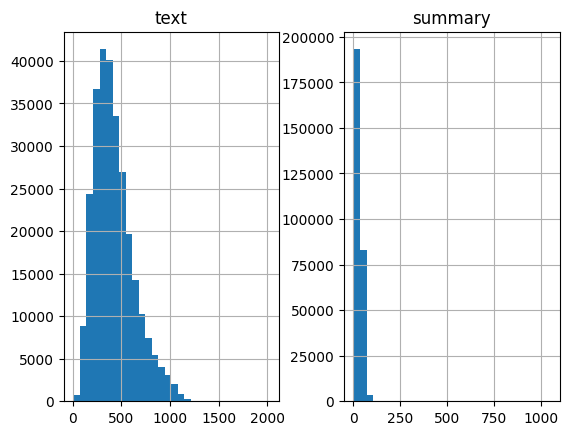

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in clean_df['text']:
      text_word_count.append(len(i.split()))

for i in clean_df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Let us now check the 90th percentile of the length of the summaries as well as the textual data.

In [18]:
# checking the 90th percentile of the lengths of summaries and text
max_len_text = np.percentile(text_word_count, 90)
max_len_summary = np.percentile(summary_word_count, 90)
print(max_len_text)
print(max_len_summary)

712.0
48.0


The below code is to shorten the text and summaries according to the 90th percentile and store them in a new dataframe.

In [19]:
cleaned_text = np.array(clean_df['text'])
cleaned_summary = np.array(clean_df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

short_df = pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
short_df['summary'] = short_df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

This code adds a "Start of sequence token" **(sostok)** and a "End of sequence token" **(eostok)** to help guide the model's summary generation process. During training, **sostok** helps the model understand where to begin generating text, and **eostok** signals when to stop, avoiding endless or incorrect generation.

## Word Coverage Analysis

Using this analysis, we can understand the number of words overlapping between summaries and their texts. This helps decide the type of summarization task (**extractive** or **abstractive**) to be undertaken.

In [21]:
def coverage(text, summary):
    text_words = set(text.split())
    summary_words = set(summary.split())
    return len(summary_words & text_words) / len(summary_words)

count    231138.000000
mean          0.762973
std           0.108016
min           0.000000
25%           0.700000
50%           0.777778
75%           0.842105
max           0.960000
Name: coverage, dtype: float64


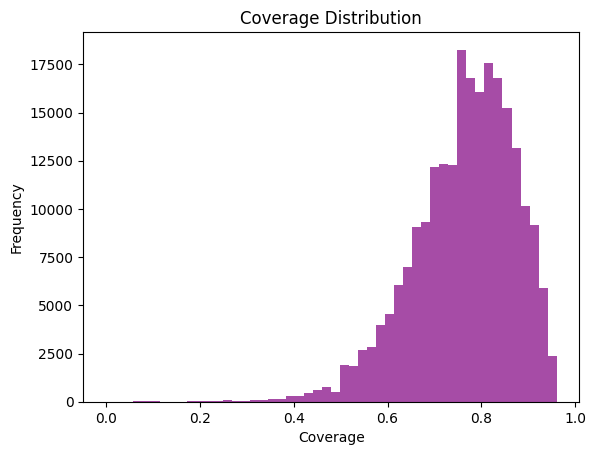

In [22]:
short_df['coverage'] = short_df.apply(lambda row: coverage(row['text'], row['summary']), axis=1)

# Summary statistics
print(short_df['coverage'].describe())

# Plot distribution
plt.hist(short_df['coverage'], bins=50, color='purple', alpha=0.7)
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Coverage Distribution')
plt.show()

From the above coverage distribution, it is clear that most of the words present in the summaries are covered in their respective texts, i.e., the summaries represent a **good portion** of what the text is trying to convey. The distribution is right-skewed and it peaks at values between **0.7** and **0.8**, suggesting that this is an **extractive summarization** task.

There are very few values below 0.4 which might imply that these summaries are not able to capture the gist of their respective texts since they might be too complex.

# Getting our dataset loaders ready

## Splitting the dataset

In [23]:
# splitting the dataset into training and validation datasets
from sklearn.model_selection import train_test_split
x_tr, X_val, y_tr, y_val = train_test_split(np.array(short_df['text']), np.array(short_df['summary']), test_size=0.1, random_state=0, shuffle=True)

In [24]:
# further splitting the training dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.1, random_state=42, shuffle=True)

In [25]:
# checking the shapes of all the datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(187221,)
(187221,)
(20803,)
(20803,)
(23114,)
(23114,)


## Vectorization Layer

This part is essential to break down the cleaned texts into individual words (or tokens). Once the tokens are created, they are converted to sequences and padded to the maximum text length as discussed in the `Data Exploration` section.

Here, a text vectorization layer is used which is fully integrated with tensorflow.

In [26]:
max_vocab_size = 35000
max_seq_len = 100
max_sum_len = 30
embed_dim = 128

In [27]:
# Extract vocabularies from X_train and y_train
text_vocab = set([word for sentence in X_train for word in sentence.split()])
summary_vocab = set([word for sentence in y_train for word in sentence.split()])

# Merge vocabularies
merged_vocab = text_vocab.union(summary_vocab)

In [28]:
print("Text vocabulary: ", len(text_vocab))
print("Summary vocabulary: ", len(summary_vocab))
print("Merged vocabulary: ", len(merged_vocab))

Text vocabulary:  430826
Summary vocabulary:  128717
Merged vocabulary:  434560


In [29]:
# Limit the vocabulary size if necessary
if len(merged_vocab) > max_vocab_size:
    merged_vocab = list(merged_vocab)[:max_vocab_size]

In [30]:
from tensorflow.keras.layers import TextVectorization

# Create a TextVectorization layer for input variable
vectorization_layer_text = TextVectorization(
    max_tokens=max_vocab_size,
    output_sequence_length=max_seq_len
)

# Adapt tokenizer to the training data
vectorization_layer_text.adapt(merged_vocab)

In [31]:
# Apply vectorization
X_train_vectorized = vectorization_layer_text(X_train).numpy()
X_val_vectorized = vectorization_layer_text(X_val).numpy()
X_test_vectorized = vectorization_layer_text(X_test).numpy()

In [32]:
# checking the shapes of the vectorized datasets
print("Vectorized Training Data Shape:\n", X_train_vectorized.shape)
print("Vectorized Validation Data Shape:\n", X_val_vectorized.shape)
print("Vectorized Testing Data Shape:\n", X_test_vectorized.shape)

Vectorized Training Data Shape:
 (187221, 100)
Vectorized Validation Data Shape:
 (23114, 100)
Vectorized Testing Data Shape:
 (20803, 100)


In [33]:
# Create a TextVectorization layer for input variable
vectorization_layer_summary = TextVectorization(
    max_tokens=max_vocab_size,
    output_sequence_length=max_sum_len
)

# Reserve 2 slots for special tokens
effective_max_vocab_size = max_vocab_size - 2

# Reduce merged vocabulary if needed
if len(merged_vocab) > effective_max_vocab_size:
    merged_vocab = list(merged_vocab)[:effective_max_vocab_size]

# Add special tokens
merged_vocab_with_specials = merged_vocab + ['sostok', 'eostok']

# Adapt the TextVectorization layer
vectorization_layer_summary.adapt(merged_vocab_with_specials)

In [34]:
# Apply vectorization
y_train_vectorized = vectorization_layer_summary(y_train).numpy()
y_val_vectorized = vectorization_layer_summary(y_val).numpy()
y_test_vectorized = vectorization_layer_summary(y_test).numpy()

In [35]:
# checking the shapes of the vectorized datasets
print("Vectorized Target Training Data Shape:\n", y_train_vectorized.shape)
print("Vectorized Target Validation Data Shape:\n", y_val_vectorized.shape)
print("Vectorized Target Testing Data Shape:\n", y_test_vectorized.shape)

Vectorized Target Training Data Shape:
 (187221, 30)
Vectorized Target Validation Data Shape:
 (23114, 30)
Vectorized Target Testing Data Shape:
 (20803, 30)


It can be observed that each sample in the training dataset is being converted to integer values and then padded to 120 tokens, i.e., each sample after vectorization has a maximum length of `120`. Similarly, each sample in the summaries (y labels) are padded to 30 tokens.

In [36]:
def create_binary_labels(input_data, target_data, max_sum_len):
    binary_labels = np.zeros((input_data.shape[0], max_sum_len), dtype=int)
    for i, (input_seq, target_seq) in enumerate(zip(input_data, target_data)):
        target_tokens = set(target_seq[:max_sum_len]) - {0}  # Remove padding and truncate
        binary_labels[i, :min(len(input_seq), max_sum_len)] = [
            1 if token in target_tokens else 0
            for token in input_seq[:max_sum_len]
        ]
    return binary_labels

In [37]:
y_train_binary = create_binary_labels(X_train_vectorized, y_train_vectorized, max_sum_len)
y_val_binary = create_binary_labels(X_val_vectorized, y_val_vectorized, max_sum_len)
y_test_binary = create_binary_labels(X_test_vectorized, y_test_vectorized, max_sum_len)

In [38]:
# Ensure targets are expanded to match the model output shape
y_train_binary = tf.expand_dims(y_train_binary, axis=-1)  # Shape: (num_samples, max_sum_len, 1)
y_val_binary = tf.expand_dims(y_val_binary, axis=-1)
y_test_binary = tf.expand_dims(y_test_binary, axis=-1)

In [39]:
print("X_train_vectorized shape:", X_train_vectorized.shape)  # Should be (batch_size, max_seq_len)
print("y_train_vectorized shape:", y_train_vectorized.shape)  # Should be (batch_size, max_sum_len)
print("y_train_binary shape:", y_train_binary.shape)          # Should be (batch_size, max_sum_len, 1)

X_train_vectorized shape: (187221, 100)
y_train_vectorized shape: (187221, 30)
y_train_binary shape: (187221, 30, 1)


## Preparing Dataset Loaders

In [40]:
strategy = tf.distribute.MirroredStrategy()

In [41]:
import tensorflow as tf

# Define constants
batch_size_per_gpu = 256
BATCH_SIZE = batch_size_per_gpu * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_vectorized, y_train_vectorized), y_train_binary))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_vectorized, y_val_vectorized), y_val_binary))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_vectorized, y_test_vectorized), y_test_binary))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [42]:
for batch in train_dataset.take(1):
    (X_batch, y_batch), target_batch = batch
    print("X_batch shape:", X_batch.shape)          # Should be (batch_size, max_seq_len)
    print("y_batch shape:", y_batch.shape)          # Should be (batch_size, max_sum_len)
    print("target_batch shape:", target_batch.shape) # Should be (batch_size, max_sum_len, 1)

X_batch shape: (512, 100)
y_batch shape: (512, 30)
target_batch shape: (512, 30, 1)


## Setting up Mixed-Precision

In [43]:
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Check Tensor Core compatibility (optional)
device_info = tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])
print("GPU Device Info:", device_info)

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU Device Info: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [44]:
from tensorflow.keras import mixed_precision

# Enable mixed precision globally
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify policy
print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())

Mixed precision policy: <FloatDTypePolicy "mixed_float16">


# Data Preprocessing Layers

In the upcoming code snippets, I am going to register the custom layers and add them to the Tensorflow's **serialization system**, making it possible to save and load models without manually redefining the layers during deserialization. Additionally, registered custom layers can be easily deployed and integrated into production environments.

In [45]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.saving import register_keras_serializable

## Positional Embeddings

This layer is particularly useful when working with inputs where positional context significantly impacts meaning, such as in structured text or time-series data. By adding positional embeddings to the input embeddings, the model can incorporate both positional and semantic information before passing it to the Bi-LSTM layers. This hybrid approach can enhance the representation of sequences and improve downstream tasks like translation, summarization, or other sequence-to-sequence applications.

In [46]:
@register_keras_serializable(package="Custom")
class PositionalEmbeddingLayer(Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEmbeddingLayer, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.positional_embeddings = self.add_weight(
            shape=(self.max_seq_len, self.embed_dim),
            initializer="uniform",
            trainable=True,
            name="positional_embeddings"
        )

    def call(self, inputs):
        # Cast inputs to float32 to ensure compatibility
        inputs = tf.cast(inputs, dtype=tf.float32)
        
        # Assume inputs is 3D: (batch_size, seq_len, embed_dim)
        seq_len = tf.shape(inputs)[1]

        # Ensure positional embeddings have the correct dtype
        positional_embeddings = tf.cast(self.positional_embeddings[:seq_len, :], dtype=inputs.dtype)

        # Broadcast positional embeddings to match the input shape
        positional_embeddings = tf.expand_dims(positional_embeddings, axis=0)  # Shape: (1, seq_len, embed_dim)

        # Add positional embeddings to inputs
        return (inputs + positional_embeddings)

    def compute_mask(self, inputs, mask=None):
        return mask

    def get_config(self):
        config = super(PositionalEmbeddingLayer, self).get_config()
        config.update({
            "max_seq_len": self.max_seq_len,
            "embed_dim": self.embed_dim
        })
        return config

## Dynamic Attention Layer

This is one of the most important sections of this project. Here, I am defining a user-defined `Optimized Dynamic Local Attention` layer. In this layer, a local attention mechanism is implemented which focuses only on particular subset of encoder outputs within a dynamic window around the decoder step. But in contrast to the fixed window-size local attention, I have implemented an advanced version of local attention layer where the window sizes are **dynamic**, i.e., the window sizes keep changing according to the length of the input sequence length.

Additionally, these window sizes are calculated using **dynamic window ratios** which are learnt while training the model using a vanilla **Dense** network that outputs the ratio between **0** and **1**. In order to decrease the computational load and make it more efficient, I have set a hard cap on the window size values (=50).

In [47]:
@register_keras_serializable(package="Custom")
class DynamicWindowAttention(Layer):
    def __init__(self, max_window_size=50, embed_dim=128, **kwargs):
        super(DynamicWindowAttention, self).__init__(**kwargs)
        self.max_window_size = max_window_size
        self.embed_dim = embed_dim
        self.ratio_predictor = Dense(1, activation="sigmoid", name="ratio_predictor")

    def build(self, input_shape):
        """
        Define layer-specific variables based on the input shapes.
        input_shape: [encoder_outputs_shape, decoder_outputs_shape, seq_lengths_shape]
        """
        # Validate input dimensions
        if len(input_shape) != 3:
            raise ValueError("Expected inputs to be a list of 3 tensors: "
                             "[encoder_outputs, decoder_outputs, seq_lengths].")
        
        # Save shapes for reference
        self.encoder_shape = input_shape[0]  # Shape: (batch_size, seq_len, embed_dim)
        self.decoder_shape = input_shape[1]  # Shape: (batch_size, target_seq_len, embed_dim)
        self.seq_lengths_shape = input_shape[2]  # Shape: (batch_size,)

        # Ensure embedding dimensions match
        if self.encoder_shape[-1] != self.decoder_shape[-1]:
            raise ValueError("Encoder and decoder embedding dimensions must match.")

        # Mark the layer as built
        super(DynamicWindowAttention, self).build(input_shape)

    def call(self, inputs):
        """
        Vectorized implementation for dynamic window attention.
        inputs: List of inputs [encoder_outputs, decoder_outputs, seq_lengths]
        encoder_outputs: (batch_size, seq_len, embed_dim)
        decoder_outputs: (batch_size, target_seq_len, embed_dim)
        seq_lengths: (batch_size,)
        """
        encoder_outputs, decoder_outputs, seq_lengths = inputs
        encoder_outputs = tf.cast(encoder_outputs, tf.float32)
        decoder_outputs = tf.cast(decoder_outputs, tf.float32)
        seq_lengths = tf.cast(seq_lengths, tf.float32)  # Convert to float32 for arithmetic

        # Predict dynamic window ratios
        dynamic_ratios = tf.squeeze(self.ratio_predictor(decoder_outputs), axis=-1)  # Shape: (batch_size, target_seq_len)
        dynamic_ratios = tf.cast(dynamic_ratios, tf.float32)

        # Compute dynamic window sizes
        dynamic_window_sizes = tf.cast(tf.math.ceil(dynamic_ratios * seq_lengths[:, tf.newaxis]), tf.int32)  # Shape: (batch_size, target_seq_len)
        dynamic_window_sizes = tf.minimum(dynamic_window_sizes, self.max_window_size)  # Cap to max_window_size

        # Create window masks for all decoder steps
        batch_size = tf.shape(encoder_outputs)[0]
        max_seq_len = tf.shape(encoder_outputs)[1]
        target_seq_len = tf.shape(decoder_outputs)[1]

        # Expand seq_lengths and dynamic_window_sizes for broadcasting
        seq_lengths_expanded = tf.tile(seq_lengths[:, tf.newaxis], [1, target_seq_len])
        window_masks = tf.sequence_mask(dynamic_window_sizes, maxlen=max_seq_len)  # Shape: (batch_size, target_seq_len, max_seq_len)

        # Expand window masks for embedding dimensions
        window_masks_expanded = tf.expand_dims(window_masks, axis=-1)  # Shape: (batch_size, target_seq_len, max_seq_len, 1)

        # Mask encoder outputs for each decoder step
        masked_encoder_outputs = tf.expand_dims(encoder_outputs, axis=1) * tf.cast(window_masks_expanded, encoder_outputs.dtype)  # Shape: (batch_size, target_seq_len, max_seq_len, embed_dim)

        # Compute attention scores
        attention_scores = tf.nn.softmax(
            tf.matmul(
                tf.expand_dims(decoder_outputs, axis=2),  # Shape: (batch_size, target_seq_len, 1, embed_dim)
                masked_encoder_outputs,
                transpose_b=True
            ),
            axis=-1
        )  # Shape: (batch_size, target_seq_len, 1, max_seq_len)

        # Compute attention outputs
        attention_outputs = tf.matmul(attention_scores, masked_encoder_outputs)  # Shape: (batch_size, target_seq_len, 1, embed_dim)
        attention_outputs = tf.squeeze(attention_outputs, axis=2)  # Shape: (batch_size, target_seq_len, embed_dim)

        return attention_outputs

    def get_config(self):
        config = super(DynamicWindowAttention, self).get_config()
        config.update({
            "max_window_size": self.max_window_size,
            "embed_dim": self.embed_dim
        })
        return config

In [48]:
# Test PositionalEmbeddingLayer
pos_emb_layer = PositionalEmbeddingLayer(max_seq_len=120, embed_dim=128)

# Example inputs
batch_size = 8
seq_len = 120
vocab_size = 10000
embedding_dim = 128

# Token embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)

# Generate random token indices
x = tf.random.uniform((batch_size, seq_len), maxval=vocab_size, dtype=tf.int32)  # Random test input

# Embed the token indices
embedded_inputs = embedding_layer(x)

# Pass through positional embedding layer
output = pos_emb_layer(embedded_inputs)
print("PositionalEmbeddingLayer Output Shape:", output.shape)

PositionalEmbeddingLayer Output Shape: (8, 120, 128)


In [49]:
# Dummy inputs
batch_size = 8
seq_len = 120
target_seq_len = 30
embed_dim = 128

encoder_outputs_dummy = tf.random.normal((batch_size, seq_len, 512), dtype=tf.float32)  # Encoder outputs
decoder_outputs_dummy = tf.random.normal((batch_size, target_seq_len, 512), dtype=tf.float32)  # Decoder outputs
seq_lengths_dummy = tf.constant([seq_len] * batch_size, dtype=tf.int32)  # Sequence lengths

# Instantiate and call the layer
dynamic_attention_layer = DynamicWindowAttention(max_window_size=50, embed_dim=512)
attention_outputs = dynamic_attention_layer([encoder_outputs_dummy, decoder_outputs_dummy, seq_lengths_dummy])

print("Attention Outputs Shape:", attention_outputs.shape)  # Expected: (32, 30, 512)

Attention Outputs Shape: (8, 30, 512)


# Model Architecture

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed
import tensorflow as tf

# Define input parameters
max_vocab_size = len(merged_vocab_with_specials)
max_seq_len = 100
max_sum_len = 30
embed_dim = 128
hidden_dim = 256
max_window_size = 50

In [51]:
max_vocab_size

35000

In [52]:
@register_keras_serializable(package="Custom")
class SequenceLengthLayer(Layer):
    def call(self, inputs):
        # Calculate sequence lengths dynamically
        return tf.reduce_sum(tf.cast(inputs != 0, tf.int32), axis=1)

    def get_config(self):
        config = super(SequenceLengthLayer, self).get_config()
        return config

To avoid exploding gradients, I am going to implement gradient clipping to restrict the gradient values.

Furthermore, I am going to implement a **learning rate scheduler** to keep the learning rate in check and reduce the learning rate in regular intervals to ensure smooth transitions and avoid any sudden accuracy drops while training.

In [53]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)

In [54]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [55]:
with strategy.scope():
    # Inputs
    encoder_inputs = Input(shape=(max_seq_len,), dtype="int32", name="encoder_inputs")
    decoder_inputs = Input(shape=(max_sum_len,), dtype="int32", name="decoder_inputs")
    
    # Token Embedding Layer
    token_embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embed_dim, mask_zero=True, name="token_embedding")
    
    # Positional Embedding Layer
    positional_embedding_layer_encoder = PositionalEmbeddingLayer(max_seq_len=max_seq_len, embed_dim=embed_dim)
    positional_embedding_layer_decoder = PositionalEmbeddingLayer(max_seq_len=max_sum_len, embed_dim=embed_dim)
    
    # Encoder
    embedded_encoder_inputs = positional_embedding_layer_encoder(token_embedding_layer(encoder_inputs))  # Add positional embeddings
    embedded_encoder_inputs = BatchNormalization()(embedded_encoder_inputs)  # Normalize embeddings
    
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(hidden_dim, return_sequences=True, return_state=True), name="bi_lstm_1"
    )(embedded_encoder_inputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)  # Normalize LSTM outputs
    
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(hidden_dim, return_sequences=True, return_state=True), name="bi_lstm_2"
    )(encoder_outputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)  # Normalize LSTM outputs
    
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(hidden_dim, return_sequences=True, return_state=True), name="bi_lstm_3"
    )(encoder_outputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)  # Normalize LSTM outputs
    
    # Combine forward and backward states
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])  # Shape: (batch_size, 2*hidden_dim)
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])  # Shape: (batch_size, 2*hidden_dim)
    
    # Decoder
    embedded_decoder_inputs = positional_embedding_layer_decoder(token_embedding_layer(decoder_inputs))  # Add positional embeddings
    embedded_decoder_inputs = BatchNormalization()(embedded_decoder_inputs)  # Normalize embeddings
    
    decoder_lstm_1 = LSTM(2 * hidden_dim, return_sequences=True, return_state=True, dropout=0.05, recurrent_dropout=0.05, name="lstm_1")
    decoder_lstm_2 = LSTM(2 * hidden_dim, return_sequences=True, return_state=True, dropout=0.05, recurrent_dropout=0.05, name="lstm_2")
    decoder_lstm_3 = LSTM(2 * hidden_dim, return_sequences=True, return_state=True, dropout=0.05, recurrent_dropout=0.05, name="lstm_3")
    
    decoder_outputs, _, _ = decoder_lstm_1(embedded_decoder_inputs, initial_state=[state_h, state_c])
    decoder_outputs = BatchNormalization()(decoder_outputs)  # Normalize LSTM outputs
    
    decoder_outputs, _, _ = decoder_lstm_2(decoder_outputs)
    decoder_outputs = BatchNormalization()(decoder_outputs)  # Normalize LSTM outputs
    
    decoder_outputs, _, _ = decoder_lstm_3(decoder_outputs)
    decoder_outputs = BatchNormalization()(decoder_outputs)  # Normalize LSTM outputs
    
    # Dynamic Window Attention
    seq_lengths_layer = SequenceLengthLayer()  # Use the custom layer
    seq_lengths = seq_lengths_layer(encoder_inputs)  # Compute sequence lengths dynamically
    
    dynamic_attention_layer = DynamicWindowAttention(max_window_size=max_window_size, embed_dim=2 * hidden_dim)
    attention_outputs = dynamic_attention_layer([encoder_outputs, decoder_outputs, seq_lengths])
    attention_outputs = BatchNormalization()(attention_outputs)  # Normalize attention outputs
    
    # TimeDistributed Dense Layer (binary classification for extractive summarization)
    output_layer = TimeDistributed(Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01)), name="outputs")
    final_outputs = output_layer(attention_outputs)
    
    # Build and compile the model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs)

    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4, clipnorm=1.0)  # Clip gradients to a max norm of 1.0
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

    # Define EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [56]:
# checking the model structure
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 30, 128)   │  4,480,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 100, 128)  │     12,800 │ token_embedding[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100)       │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ positional_embed… │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ [(None, 100,      │    788,480 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ bi_lstm_1[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ [(None, 100,      │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ bi_lstm_2[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_3           │ [(None, 100,      │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 30, 128)   │      3,840 │ token_embedding[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 30)        │          0 │ decoder_inputs[0

 Total params: 13,962,498 (53.26 MB)

 Trainable params: 13,954,818 (53.23 MB)

 Non-trainable params: 7,680 (30.00 KB)

## Model Training

In [99]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 266s 545ms/step - accuracy: 0.8478 - loss: 0.4363 - val_accuracy: 0.8483 - val_loss: 0.4589 - learning_rate: 1.0000e-04
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 193s 527ms/step - accuracy: 0.9102 - loss: 0.4063 - val_accuracy: 0.9232 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 193s 525ms/step - accuracy: 0.9178 - loss: 0.4004 - val_accuracy: 0.9225 - val_loss: 0.3955 - learning_rate: 1.0000e-04
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 193s 527ms/step - accuracy: 0.9220 - loss: 0.3971 - val_accuracy: 0.9224 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 194s 529ms/step - accuracy: 0.9343 - loss: 0.3906 - val_accuracy: 0.9349 - val_loss: 0.3895 - learning_rate: 1.0000e-04
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 193s 527ms/step - accuracy: 0.9390 - loss: 0.3872 - val_accuracy: 0.9392 - val_loss: 0.3865 - learning_rate: 1.0000e-04
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 

## Saving the model architecture and weights

In [105]:
# Save model architecture to JSON
model_json = model.to_json()
with open("bilstm_dyn_att_3.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved to JSON.")

Model architecture saved to JSON.


In [106]:
# Save model weights
model.save_weights("bilstm_dyn_att_3.weights.h5")
print("Model weights saved successfully.")

Model weights saved successfully.


In [107]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/bilstm_dyn_att_3.weights.h5
/kaggle/working/bilstm_dyn_att_2.weights.h5
/kaggle/working/bilstm_dyn_att_3.json
/kaggle/working/bilstm_dyn_att_2.json


In [77]:
# Save text vectorizer with a valid `.keras` extension
tf.keras.models.save_model(tf.keras.Sequential([vectorization_layer_text]), 'text_vectorizer.keras')

# Save summary vectorizer with a valid `.keras` extension
tf.keras.models.save_model(tf.keras.Sequential([vectorization_layer_summary]), 'summary_vectorizer.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


## Loading the model architecture and weights

In [57]:
from tensorflow.keras.models import model_from_json

# Load model architecture from JSON
with open("/kaggle/input/final_model/tensorflow2/default/1/bilstm_dyn_att_3.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Provide custom layers
custom_objects = {
    "SequenceLengthLayer": SequenceLengthLayer,
    "DynamicWindowAttention": DynamicWindowAttention,
    "PositionalEmbeddingLayer": PositionalEmbeddingLayer,
}

# Deserialize the model
new_model = model_from_json(loaded_model_json, custom_objects=custom_objects)

print("Model architecture loaded successfully.")

Model architecture loaded successfully.


In [58]:
# Load weights into the model
new_model.load_weights("/kaggle/input/final_model/tensorflow2/default/1/bilstm_dyn_att_3.weights.h5")
print("Model weights loaded successfully.")

Model weights loaded successfully.


In [59]:
# check the loaded model summary
new_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 30, 128)   │  4,480,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 100, 128)  │     12,800 │ token_embedding[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 100)       │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ positional_embed… │
│ (BatchNormalizatio… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ [(None, 100,      │    788,480 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal_4[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ bi_lstm_1[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ [(None, 100,      │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal_4[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ bi_lstm_2[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_3           │ [(None, 100,      │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal_4[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 30, 128)   │      3,840 │ token_embedding[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 30)        │          0 │ decoder_inputs[0

 Total params: 41,872,140 (159.73 MB)

 Trainable params: 13,954,818 (53.23 MB)

 Non-trainable params: 7,680 (30.00 KB)

 Optimizer params: 27,909,642 (106.47 MB)

In [60]:
# Load text vectorizer
loaded_text_vectorizer_model = tf.keras.models.load_model('/kaggle/input/vectorizers/keras/default/1/text_vectorizer_v1.keras')
vectorization_layer_text = loaded_text_vectorizer_model.layers[0]

# Load summary vectorizer
loaded_summary_vectorizer_model = tf.keras.models.load_model('/kaggle/input/vectorizers/keras/default/1/summary_vectorizer_v1.keras')
vectorization_layer_summary = loaded_summary_vectorizer_model.layers[0]

## Evaluating the Model

In [61]:
loss, accuracy = new_model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.9379 - loss: 0.3819
Test Loss: 0.38188666105270386, Test Accuracy: 0.9379913210868835


In [62]:
for layer in new_model.layers:
    print(layer.name)

encoder_inputs
token_embedding
positional_embedding_layer_6
batch_normalization_18
bi_lstm_1
batch_normalization_19
bi_lstm_2
decoder_inputs
batch_normalization_20
bi_lstm_3
positional_embedding_layer_7
batch_normalization_22
concatenate_4
concatenate_5
lstm_1
batch_normalization_23
lstm_2
batch_normalization_24
lstm_3
batch_normalization_21
batch_normalization_25
sequence_length_layer_2
dynamic_window_attention_4
batch_normalization_26
outputs


In [63]:
# Define a new model to output attention weights
attention_model = tf.keras.Model(
    inputs=new_model.input,
    outputs=new_model.get_layer(name="dynamic_window_attention_4").output
)

In [64]:
def get_attention_weights(attention_model, input_text, vectorization_layer_text, vectorization_layer_summary, max_sum_len):
    """
    Extracts and processes attention weights for visualization.

    Args:
        attention_model: Model that outputs attention weights.
        input_text: Input text for which to compute attention.
        vectorization_layer_text: Text vectorization layer for input text.
        vectorization_layer_summary: Text vectorization layer for summaries.
        max_sum_len: Maximum sequence length for decoder input.

    Returns:
        attention_weights: Reduced attention weights.
        input_tokens: List of input tokens.
        predicted_tokens: List of predicted tokens.
    """
    # Tokenize and pad input text using the vectorization layer
    encoder_input = vectorization_layer_text(tf.constant([input_text])).numpy()

    # Initialize decoder input with <START> token
    vocab_summary = vectorization_layer_summary.get_vocabulary()
    start_token_index = vocab_summary.index("sostok")
    decoder_input = np.array([[start_token_index] + [0] * (max_sum_len - 1)])

    # Get attention outputs
    attention_outputs = attention_model.predict([encoder_input, decoder_input], verbose=0)
    
    # Reduce attention dimensionality
    attention_weights = attention_outputs[0].mean(axis=-1)  # Shape: (30,)
    
    # Decode input tokens
    vocab_text = vectorization_layer_text.get_vocabulary()
    index_to_word_text = {i: word for i, word in enumerate(vocab_text)}
    input_tokens = [index_to_word_text[token] for token in encoder_input[0] if token != 0]

    # Decode predicted tokens
    predicted_tokens = [index_to_word_text.get(start_token_index, '[UNK]')]  # For now, use start token as an example

    return attention_weights, input_tokens, predicted_tokens

In [65]:
# def get_attention_weights(attention_model, input_text, vectorization_layer_text, vectorization_layer_summary, max_sum_len):
#     """
#     Extracts and visualizes attention weights.
#     """
#     # Tokenize and pad input text using the vectorization layer
#     encoder_input = vectorization_layer_text(tf.constant([input_text])).numpy()

#     # Initialize decoder input with <START> token
#     vocab_summary = vectorization_layer_summary.get_vocabulary()
#     start_token_index = vocab_summary.index("sostok")
#     decoder_input = np.array([[start_token_index] + [0] * (max_sum_len - 1)])

#     # Get attention outputs
#     attention_outputs = attention_model.predict([encoder_input, decoder_input], verbose=0)
#     print("Attention Model Outputs:", attention_outputs)  # Debug the output

#     return attention_outputs

In [66]:
# input_text = "The quick brown fox jumps over the lazy dog."
# attention_outputs = get_attention_weights(
#     attention_model, input_text, vectorization_layer_text, vectorization_layer_summary, max_sum_len=30
# )

In [67]:
# print("Attention Outputs Shape:", attention_outputs.shape)

In [68]:
def plot_attention_weights(input_tokens, attention_weights):
    """
    Plots a bar chart of attention weights for input tokens.

    Args:
        input_tokens: List of input tokens.
        attention_weights: Attention weights for each token.
    """
    plt.figure(figsize=(10, 2))
    plt.bar(range(len(input_tokens)), attention_weights[:len(input_tokens)], color='blue')
    plt.xticks(ticks=range(len(input_tokens)), labels=input_tokens, rotation=45)
    plt.xlabel("Input Tokens")
    plt.ylabel("Attention Weights")
    plt.title("Attention Weights for Input Tokens")
    plt.show()

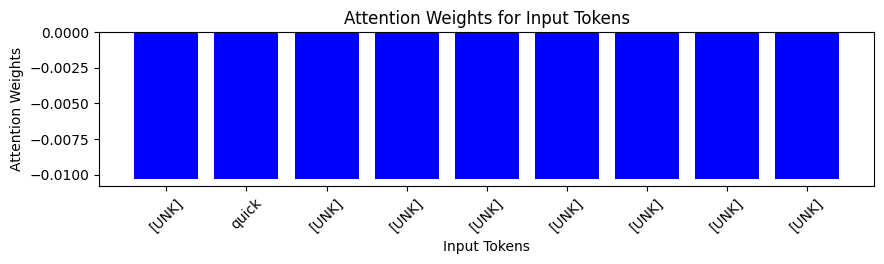

In [69]:
input_text = "The quick brown fox jumps over the lazy dog."
attention_weights, input_tokens, predicted_tokens = get_attention_weights(
    attention_model, input_text, vectorization_layer_text, vectorization_layer_summary, max_sum_len=30
)

plot_attention_weights(input_tokens, attention_weights)

In [70]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

In [71]:
# Predict and evaluate
y_true = []
y_pred = []

for (encoder_input, decoder_input), true_labels in test_dataset:
    encoder_input = tf.cast(encoder_input, tf.int32)
    decoder_input = tf.cast(decoder_input, tf.int32)
    
    predicted_probs = new_model.predict([encoder_input, decoder_input], verbose=0)
    predicted_classes = (predicted_probs > 0.5).astype(int).flatten()
    
    y_true.extend(true_labels.numpy().flatten())
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.9674


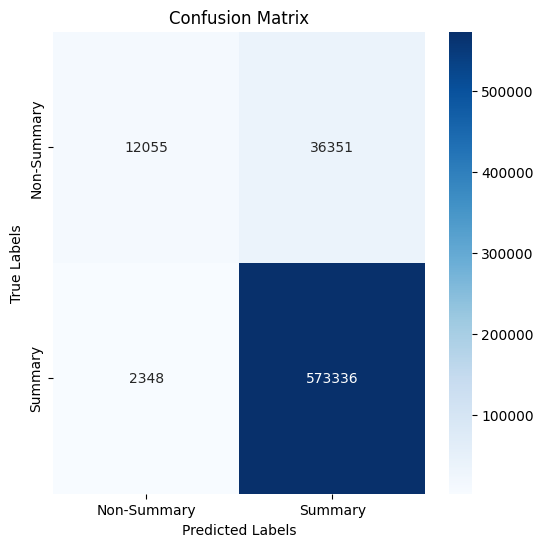

In [72]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names=["Non-Summary", "Summary"])

In [73]:
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

def calculate_bleu_scores_by_ngram(model, test_dataset, vectorizer_summary, max_sum_len):
    """
    Calculates BLEU scores for unigram, bigram, and trigram precision.

    Args:
        model: Trained Seq2Seq model.
        test_dataset: tf.data.Dataset object containing test data.
        vectorizer_summary: TextVectorization layer for decoding summaries.
        max_sum_len: Maximum length of the generated summary.

    Returns:
        Dictionary containing BLEU scores for unigram, bigram, and trigram.
    """
    vocab = vectorizer_summary.get_vocabulary()
    index_to_word = {index: word for index, word in enumerate(vocab)}

    references = []
    hypotheses = []

    for (encoder_input, decoder_input), true_summary in test_dataset:
        # Predict probabilities for the test input
        encoder_input = tf.cast(encoder_input, tf.int32)
        decoder_input = tf.cast(decoder_input, tf.int32)

        predicted_probs = model.predict([encoder_input, decoder_input], verbose=0)
        predicted_classes = (predicted_probs > 0.5).astype(int)

        # Decode true summary
        true_summary_tokens = [index_to_word.get(idx, '') for idx in true_summary.numpy().flatten() if idx != 0]
        references.append([true_summary_tokens])  # BLEU expects a list of references

        # Decode predicted summary
        predicted_summary_tokens = [
            index_to_word.get(idx, '') for idx in predicted_classes.flatten() if idx != 0
        ]
        hypotheses.append(predicted_summary_tokens)

    # Compute BLEU scores for different n-grams
    bleu_scores = {
        'Unigram': corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0)),
        'Bigram': corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0)),
        'Trigram': corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    }

    return bleu_scores

In [74]:
def plot_bleu_scores(bleu_scores):
    """
    Plots BLEU scores for unigram, bigram, and trigram precision.

    Args:
        bleu_scores: Dictionary containing BLEU scores for different n-grams.
    """
    n_grams = list(bleu_scores.keys())
    scores = list(bleu_scores.values())

    plt.figure(figsize=(8, 5))
    plt.bar(n_grams, scores, color=['blue', 'orange', 'green'], alpha=0.7)
    plt.ylim(0, 1)
    plt.title('BLEU Scores for Different n-grams')
    plt.ylabel('BLEU Score')
    plt.xlabel('n-gram')
    plt.show()

In [75]:
# Example usage
bleu_scores = calculate_bleu_scores_by_ngram(
    model=model,
    test_dataset=test_dataset,
    vectorizer_summary=vectorization_layer_summary,
    max_sum_len=30
)

print(bleu_scores)

{'Unigram': 0.9229950313685942, 'Bigram': 0.9229925002239838, 'Trigram': 0.9237299209668581}


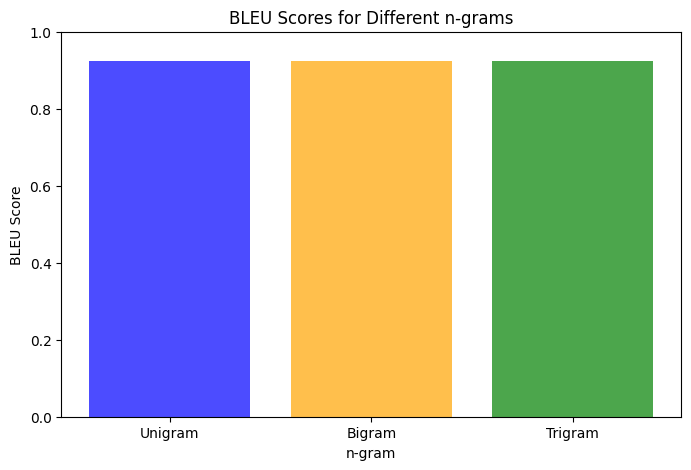

In [76]:
plot_bleu_scores(bleu_scores)